# Linear Regression with Inner Product Estimation

This notebook performs a simulation of Linear Regression using the quantum inner product estimation algorithm.

Regression is the task of estimating the function $ f : \mathbb{R}^d \to \mathbb{R} $.

Linear Regression constrains the function to be estimated to the form $ f(x) = w_1 x_1 + \dots + w_d x_d + w_0 $

In [1]:
 # Import statements

import math
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from sklearn import linear_model

# Global Variables

This cell contains the global variables that should be changed to receive a different simulation outcome. The other cells do not need to be modified.

In [2]:
# Global variables

# The number of dimensions d.
# If d = 1, then one can visaulize the function using matplotlib. Keep this at 1 to see plots.
dimensions = 1

# The minimum and maximum of the randomly generated weights of the true function 
# (slope and intersect of 1D function).
weight_min = -1.0
weight_max = 1.0

# The number of datapoints that should be generated in the training set.
num_train_datapoints = 1000

# The minimum and maximum values of the randomly generated x vectors used for training.
x_min_train = -5.0
x_max_train = 5.0

# The error in the training set
noise_sigma_train = 0.5

# The number of datapoints that should be predicted.
# The computational complexity of the simulation scales linearly with this variable.
num_predict_datapoints = 100000

# The minimum and maximum values of the randomly generated x vectors used for prediction.
x_min_predict = -5.0
x_max_predict = 5.0

# The number of qubits used for phase estimation.
# The compuational complexity of the simulation scales as O( 2^n ) or
# as O( 2^(2n) ) if Gaussian noise is added to the phase estimation state.
# It is probably best to stay below ~12 here or only predict very few datapoints.
n = 10

# Whether or not to add Gaussian noise to the output state of the phase estimation algorithm.
add_gaussian_noise_at_phase_estimation = False

# The noise parameter of the Gaussian noise added to the output state of the phase estimation algorithm.
sigma_gaussian_noise_phase_esitmation = 0.005

# Whether or not to add Gaussian nosie to the input vectors (weights and prediction xs).
add_gaussian_noise_at_input_vectors = False

# The noise parameter of the Gaussian noise added to the input vectors.
sigma_gaussian_noise_input_vectors = 0.01

# Gaussian Function

This Python function calculates the probability density function of the Guassian distirbution: 

## $ f_{\mu,\sigma}(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2} $

In [3]:
def gaussian(mu, sigma, x) :    
    probability = 1.0/(sigma * math.sqrt(2.0 * math.pi)) * math.exp( - (x - mu)**2 / (2.0 * sigma**2))
    return probability

# Discrete Gaussian Distribution

Given a specific Gaussian Distribution (i.e. given $ \mu $ and $ \sigma $), this function will calculate the probability of each $ x $ in *values* and will assume that these are all the possible values that $ x $ can attain. Thus it will normalize the probabilities such that: 

## $ \sum_{x \in \textit{values}} f_{\mu,\sigma}(x) = 1$

In [4]:
def gaussian_discrete(mu, sigma, values)  : 
    gaussian_probabilites = np.empty(shape=values.shape)
    for i, x in enumerate(values):
        gaussian_probabilites[i] = gaussian(mu, sigma, x)
    gaussian_probabilites = gaussian_probabilites/sum(gaussian_probabilites)
    return gaussian_probabilites

# Discrete Gaussian Distributions for all Phase Values

This Python function calculates $ 2^n $ discrete Gaussian distributions that are centered at each possible phase value $ ( 0, \frac{1}{2^n}, \frac{2}{2^n}, \dots, \frac{2^n-1}{2^n} ) $. The values that the discrete Guassian distribution is calculated at are also these phase values. Thus we end up with a matrix that is $ 2^n \times 2^n $. Rerun this cell if you change add_gaussian_noise_at_phase_estimation, n or sigma_gaussian_noise_phase_esitmation.

In [5]:
def all_discrete_gaussians(sigma) :
    # All possible phase values when doing phase estimation using n qubits
    phase_values = np.arange(0, (2**n), 1)/(2**n)
    
    # Uses multiprocessing to achieve the highest performance possible on the machine.
    print("Using " + str(mp.cpu_count()) + " processes to calculate all discrete Gaussians.")
    pool = mp.Pool(mp.cpu_count())
    
    all_discrete_gaussians = pool.starmap(gaussian_discrete, [(mu, sigma, phase_values) for mu in phase_values])
    
    pool.close()
    print("Finished calulcating all discrete Gaussians.")
    return all_discrete_gaussians

# Assign a default value if the noise is not used
all_discrete_gaussians_for_phase_estimation = [[]]

if add_gaussian_noise_at_phase_estimation :
    all_discrete_gaussians_for_phase_estimation = all_discrete_gaussians(sigma_gaussian_noise_phase_esitmation)

# Phase Estimation

This algorithm outputs a phase estimation value for the phase *omega*, according to the probability distribution that is attained when using the quantum phase estimation algorithm (see [1]). The probability to measure the state $ |(b + l) \mod 2^n \rangle $ is given by:

## $ p_l =  \frac{1}{2^{2n}} \frac{\sin^2( \pi  (2^n \delta - l))}{\sin^2( \pi (\delta - l / 2^n))} $

where $ b \in \{ 0, 1, \dots 2^n\} $ is the closest integer value to $ \omega \cdot 2^n $ and $ \delta = \omega - b/2^n $.

[1] : Quantum Computation and Quantum Information by Nielsen & Chuang, *10th Anniversary Edition*, pages 221-224.

In [6]:
def phase_estimation(omega) :
    distance_between_phase_values = 1/(2**n)
    
    integer_values = np.arange(0, (2**n), 1)
    phase_values = integer_values*distance_between_phase_values
    
    closest_integer_index = np.argmin(abs(phase_values - omega))
    closeset_integer = integer_values[closest_integer_index]
    delta = omega - phase_values[closest_integer_index]

    probabilities = 1/(2**(2*n)) * (np.sin( math.pi * ((2**n) * delta - integer_values)))**2 / (np.sin( math.pi * (delta - integer_values / (2**n))))**2

    # Since the formula is for the state b+l mod 2^n,
    # we have to shift the array by the integer b which is closest to the phase,
    # to retrieve the probability for the state l.
    probabilities = np.roll(probabilities, closeset_integer)

    if add_gaussian_noise_at_phase_estimation :
        # add a Gaussian bump at each phase value scaled by the probability to be in that phase value.
        gaussian_probabilities = probabilities[:,None] * all_discrete_gaussians_for_phase_estimation
        
        # contract the matrix by summing over all columns
        gaussian_probabilities = np.sum(gaussian_probabilities, axis=0)

        probabilities = gaussian_probabilities
    
    # pick a phase value according to the calculated probabilities.
    result = np.random.choice(phase_values, p=probabilities)
    return result

# Amplitude Estimation

Amplitude Estimation calls Phase Estimation as a subroutine and the scales the result $\omega$ by

### $ a = \sin^2 ( \pi \omega ) $

to retrieve the amplitude $ a $.

In [7]:
def amplitude_estimation(amplitude) :
    # First convert the amplitude to estimate into a phase to estimate 
    # by applying the inverse of the function.
    omega = math.asin(math.sqrt(amplitude))/math.pi
    
    estimated_phase = phase_estimation(omega)
    
    # Then convert the estimated phase into an estimated amplitude by applying the function
    estimated_amplitude = (math.sin(math.pi*estimated_phase))**2
    return estimated_amplitude

# Inner Product Estimation

The inner product estimation simulates the RIPE algorithm of [2] without the median evaluation. It takes two vectors as inputs, simulates the calculation of the inner product and returns the inner product estimation according to the distribution caused by the quantum algorithm.

[2] : https://arxiv.org/pdf/1812.03584.pdf, page 11.

In [8]:
def inner_product_estimation(vector_1, vector_2) :
    # The vectors need to have the same dimension
    assert vector_1.shape[0] == vector_2.shape[0]
    
    
    # Save the original norms for later on.
    norm_vector_1 = np.linalg.norm(vector_1)
    norm_vector_2 = np.linalg.norm(vector_2)
    
    if add_gaussian_noise_at_input_vectors :
        gaussian_noise_vector_1 = np.random.normal(0, sigma_gaussian_noise_input_vectors, size = (vector_1.shape[0], ))
        gaussian_noise_vector_2 = np.random.normal(0, sigma_gaussian_noise_input_vectors, size = (vector_2.shape[0], ))
        
        vector_1 = np.add(vector_1, gaussian_noise_vector_1)
        vector_2 = np.add(vector_2, gaussian_noise_vector_2)
    
    
    # Normalize the vectors, since that is a requirement of the RIPE algorithm (and this simulation).
    # Note that np.linalg.norm(vector_1) does not equal norm_vector_1 if gaussian noise has been added to the input vecotrs.
    normalized_vector_1 = vector_1/np.linalg.norm(vector_1)
    normalized_vector_2 = vector_2/np.linalg.norm(vector_2)

    # Exact inner product of the normalized vectors.
    normalized_exact_inner = np.dot(normalized_vector_1, normalized_vector_2)
    
    # Transform the inner product such that it lies in the interval [0,1].
    transformed_exact = (normalized_exact_inner+1)/2
    
    estimated_amplitude = amplitude_estimation(transformed_exact)
    
    # Transform the inner product estimation back into the interval [-1, 1].
    estimated_inner_product = estimated_amplitude*2.0 - 1.0
    
    # "Unnormalize" to get the correct inner product of the original vectors.
    result = estimated_inner_product * norm_vector_1 * norm_vector_2

    return result

# Exact Function and Training Set

Here we draw the exact weights and thus define the exact function from which the training set is generated. The training set has a Gaussian noise applied to it, to simulate real-life measurements of data points.

Homogeneous coordinates allow us to calculate the linear function using inner products:

$ \tilde{x} = [x_1, \dots, x_d, 1] $

$ \tilde{w} = [w_1,\dots, w_d, w_0] $

$ f(x) = \tilde{w}^T \tilde{x} $



In [9]:
exact_weights_homogeneous = np.random.rand(dimensions+1)*(weight_max-weight_min) + weight_min

print("Exact weights: " + str(exact_weights_homogeneous))

xs_train = np.random.rand(num_train_datapoints, dimensions)*(x_max_train-x_min_train) + x_min_train
xs_train_homogeneous = np.concatenate([xs_train, np.ones((num_train_datapoints,1))], axis=1)

ys_train = np.empty(num_train_datapoints)

for i, x_train_homogeneous in enumerate(xs_train_homogeneous) :
    ys_train[i] = np.dot(x_train_homogeneous, exact_weights_homogeneous) 
    
ys_train = ys_train + np.random.normal(0, noise_sigma_train, size=num_train_datapoints)

Exact weights: [-0.01965804 -0.17710912]


# Trained Weights

Classical training is used to train a Linear Regression model and get the trained weights.

Trained weights: [-0.02691147 -0.16878164]


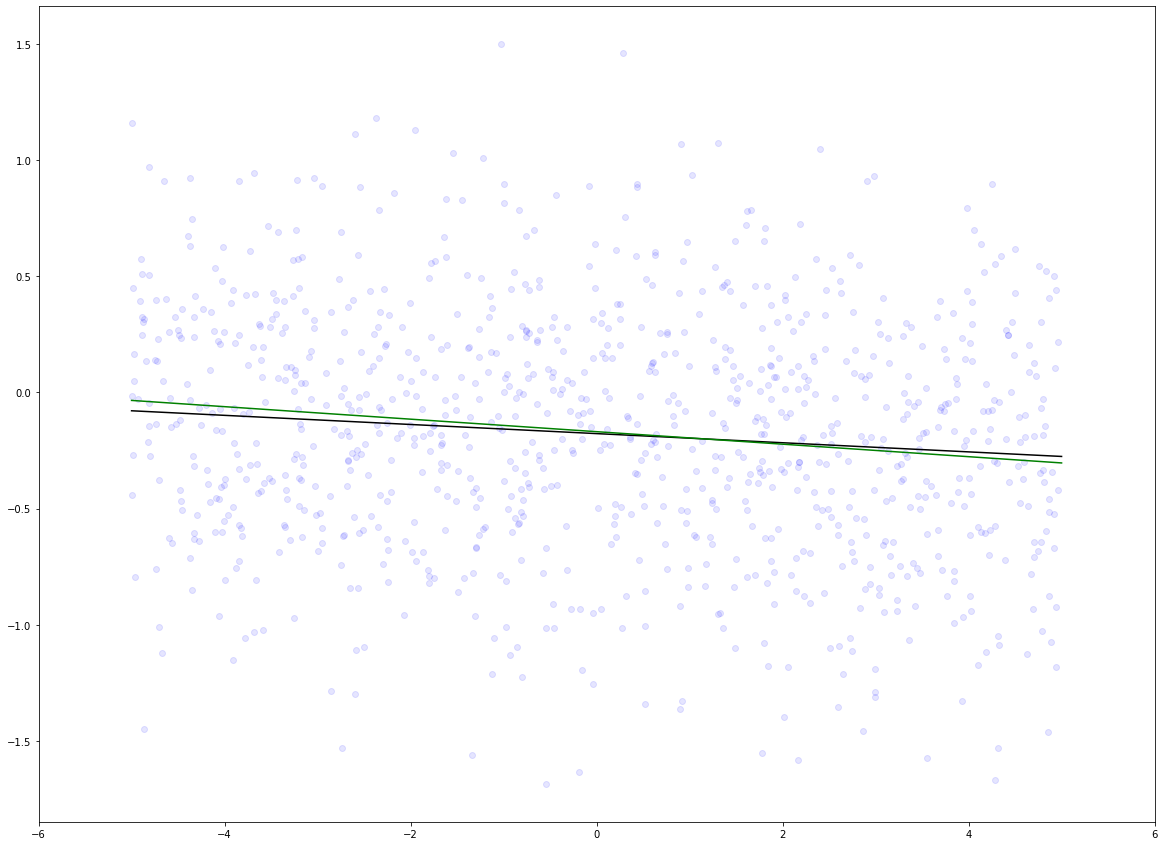

In [10]:
regr = linear_model.LinearRegression()

regr.fit(xs_train, ys_train)

coefficients = regr.coef_
intercept = regr.intercept_


trained_weights_homogeneous = np.concatenate([coefficients, [intercept]], axis=0)
print('Trained weights: ' + str(trained_weights_homogeneous))
    
if dimensions == 1 : 
    xs_func_exact = np.linspace(x_min_train,x_max_train,100)
    ys_func_exact = np.empty(100)
    for i, x_func_exact in enumerate(xs_func_exact) :
        ys_func_exact[i] = x_func_exact*exact_weights_homogeneous[0]+exact_weights_homogeneous[1]
        
    xs_func_trained = np.linspace(x_min_predict,x_max_predict,100)
    ys_func_trained = np.empty(100)
    for i, x_func_trained in enumerate(xs_func_trained) :
        ys_func_trained[i] = x_func_trained*trained_weights_homogeneous[0]+trained_weights_homogeneous[1]
        
    plt.figure(figsize=(20,15))
    
    # Blue is the training set
    plt.scatter(xs_train, ys_train, c='blue', alpha=0.1)
    
    # Black is the exact function
    plt.plot(xs_func_exact, ys_func_exact, c='black', alpha=1.0)
    
    # Green is the trained function
    plt.plot(xs_func_trained, ys_func_trained, c='green', alpha=1.0)
    
    plt.xlim((min(x_min_train, x_min_predict) - 1, max(x_max_train, x_max_predict) + 1))
    plt.show()

# Point Prediction using Inner Product Estimation

Here we plot the actual simulation of the Linear Regression using Inner Product Estimation on random prediction points.

Using 8 processes to predict 100000 values.
Finished calulcating all prediction points.


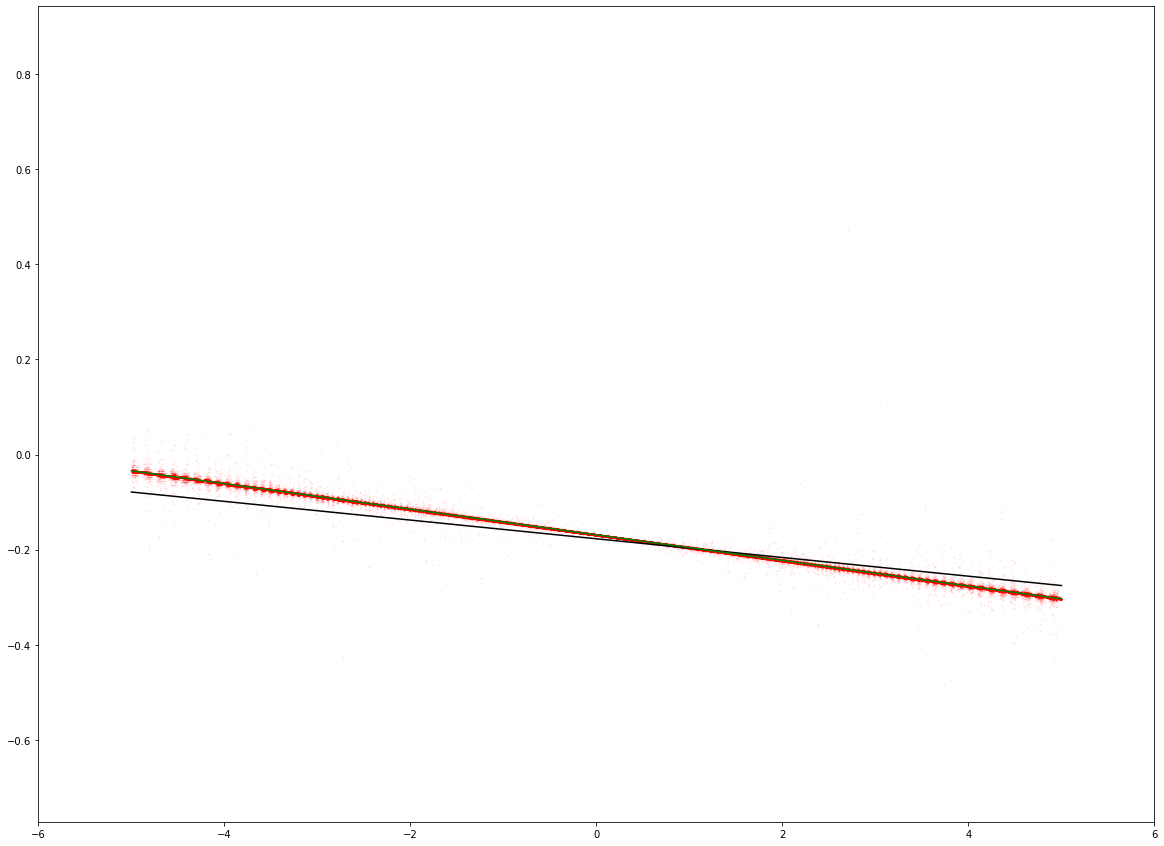

In [11]:
# Randomly choose datapoints to predict
xs_predict = np.random.rand(num_predict_datapoints, dimensions)*(x_max_predict-x_min_predict) + x_min_predict

# Make the prediction coordinates homogeneous
xs_predict_homogeneous = np.concatenate([xs_predict, np.ones((num_predict_datapoints,1))], axis=1)

# Use multiprocessing to speed up the computation
print("Using " + str(mp.cpu_count()) + " processes to predict " + str(num_predict_datapoints) +  " values.")
pool = mp.Pool(mp.cpu_count())

ys_predict = pool.starmap(inner_product_estimation, [(x_predict_homogeneous, trained_weights_homogeneous) for x_predict_homogeneous in xs_predict_homogeneous])

pool.close()

print("Finished calulcating all prediction points.")

if dimensions == 1 : 
    xs_func_exact = np.linspace(x_min_train,x_max_train,100)
    ys_func_exact = np.empty(100)
    for i, x_func_exact in enumerate(xs_func_exact) :
        ys_func_exact[i] = x_func_exact*exact_weights_homogeneous[0]+exact_weights_homogeneous[1]
        
    xs_func_trained = np.linspace(x_min_predict,x_max_predict,100)
    ys_func_trained = np.empty(100)
    for i, x_func_trained in enumerate(xs_func_trained) :
        ys_func_trained[i] = x_func_trained*trained_weights_homogeneous[0]+trained_weights_homogeneous[1]
    
    plt.figure(figsize=(20,15))
    
    # Black is the exact function
    plt.plot(xs_func_exact, ys_func_exact, c='black', alpha=1.0)
    
    # Green is the trained function
    plt.plot(xs_func_trained, ys_func_trained, c='green', alpha=1.0)
    
    # Red is the predicted points
    plt.scatter(xs_predict, ys_predict, c='red', alpha=0.05, s=1.0)

    plt.xlim((min(x_min_train, x_min_predict) - 1, max(x_max_train, x_max_predict) + 1))
    
    #plt.savefig('figs/linear_regressions_with_inner_product_estimation.png')
    
    plt.show()


Here the Linear Regression Simulation ends.

------------------------------------------

Below are other simulations, that can be useful to interpret the results.

# Inner Product Estimation Distribution Simulation

This simulation shows the distribution of the inner product estimation algorithm ouptut.

<BarContainer object of 86 artists>

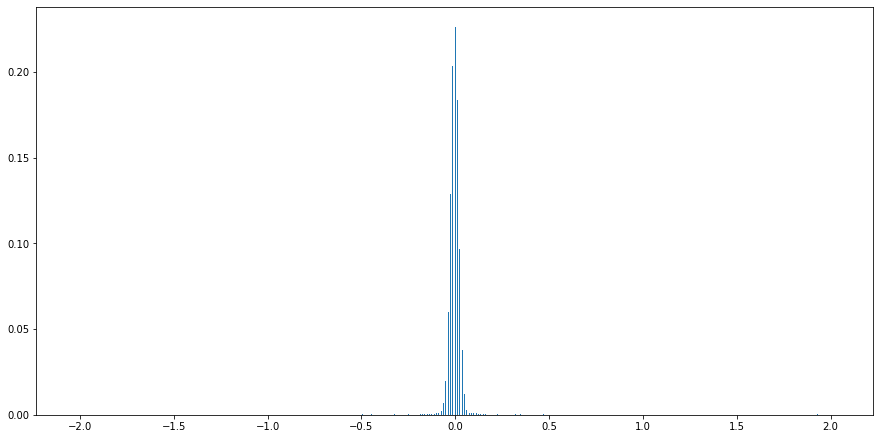

In [12]:
def simulation(number_of_runs, vector_size) :
    probability_increment = 1 / number_of_runs
    
    #random vector with values between -1 and 1
    vector_1 = np.random.rand(vector_size, )*2.0 - np.ones(vector_size, )
    vector_2 = np.random.rand(vector_size, )*2.0 - np.ones(vector_size, )
    
    exact_inner = np.dot(vector_1, vector_2)

    # empty dictionary
    simulation_results = {}
    for run in range(number_of_runs) :
        result = inner_product_estimation(vector_1, vector_2)

        if(result in simulation_results) :
            simulation_results[result] = simulation_results[result] + probability_increment
        else :
            simulation_results[result] = probability_increment

    return simulation_results

# Number of qubits
n = 10

# Whether or not to add Gaussian noise to the output state of the phase estimation algorithm.
add_gaussian_noise_at_phase_estimation = False

# The noise parameter of the Gaussian noise added to the output state of the phase estimation algorithm.
sigma_gaussian_noise_phase_esitmation = 0.005

# Whether or not to add Gaussian nosie to the input vectors (weights and prediction xs).
add_gaussian_noise_at_input_vectors = True

# The noise parameter of the Gaussian noise added to the input vectors.
sigma_gaussian_noise_input_vectors = 0.01

if add_gaussian_noise_at_phase_estimation :
    all_discrete_gaussians_for_phase_estimation = all_discrete_gaussians(sigma_gaussian_noise_phase_esitmation)


simulation_results = simulation(number_of_runs=10000, vector_size=5)
plt.figure(figsize=(15,7.5))
axes = plt.gca()

plt.bar(simulation_results.keys(), simulation_results.values(), width=0.005)

# Exact Inner Product Estimation

This simulation shows the output of the Linear Regression using Inner Product Estimation, if the Inner Product Estimation would always choose the closest integer phase value instead of the distribution

## $ p_l =  \frac{1}{2^{2n}} \frac{\sin^2( \pi  (2^n \delta - l))}{\sin^2( \pi (\delta - l / 2^n))} $

in the phase estimation algorithm.

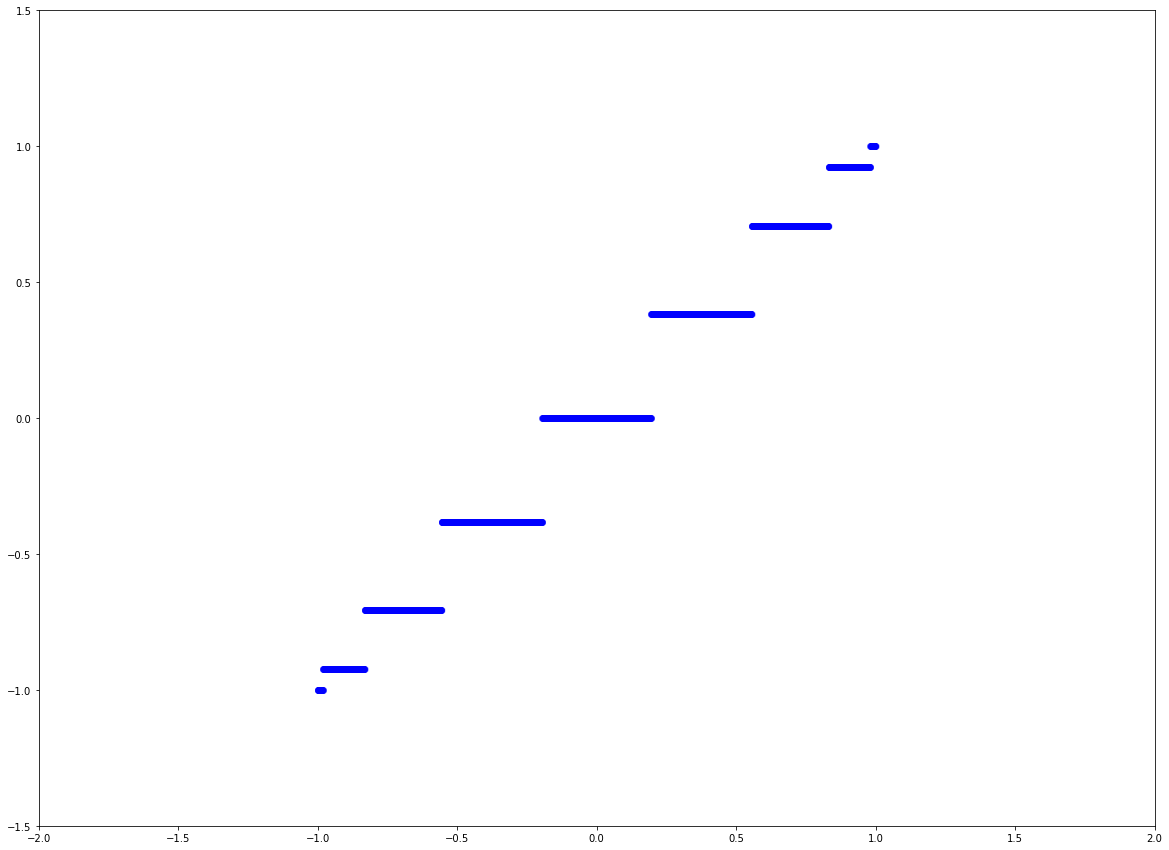

In [13]:

def find_nearest(array, value, sigma):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    noisy_index = int(idx + np.random.normal(0, sigma, size = 1))
    noisy_index = min(len(array)-1, noisy_index)
    noisy_index = max(0, noisy_index)

    return array[noisy_index]

n=4
integer_phase_values = np.arange(0, (2**n), 1)/(2**n)
sigma = 0.0

weights = [0.5, 0.45]
norm_weights = np.linalg.norm(weights)
normalized_weights = weights/norm_weights

num_points = 10000
plt.figure(figsize=(20,15))
xs_func = np.linspace(-1,1,num_points)
ys_func = np.empty(num_points)
for i, x_func in enumerate(xs_func) :
    x = [x_func, 1.0]
    norm_x = np.linalg.norm(x)
    normalized_x = x/norm_x
    normalized_inner = np.dot(normalized_weights, normalized_x)
    
    transform_inner = (x_func+1)/2
    transform_amplitude = math.asin(math.sqrt(transform_inner))/math.pi
    
    closest_int = find_nearest(integer_phase_values, transform_amplitude, sigma)

    transformed_back_amplitude = (math.sin(math.pi*closest_int))**2
    transformed_back_inner = transformed_back_amplitude*2.0 - 1.0
    
    
    ys_func[i] = transformed_back_inner #* norm_weights * norm_x
    

plot_1 = plt.scatter(xs_func, ys_func, c='blue', alpha=0.1)
plt.xlim((-2, 2))
plt.ylim((-1.5, 1.5))

plt.show()